# Section 4: Getting data and some additional regression magic

This week, we are going to learn:
* How to download data from two very popular sources in the field of political economy and macroeconomics
* Look at an interesting question related to the effectiveness of international aid.
* Learn about interaction terms and bad controls
* Maybe: Make a quick example about data visualization

In [1]:
install.packages(c('WDI','owidR','plotly','showtext','huxtable','jtools'))

library('WDI')
library('owidR')
library('ggplot2')
library('dplyr')
library('plotly')
library('huxtable')
library('tidyr')
library('showtext')
library('jtools')
library('plotly')
print('Installed required packages')

# We set a seed to make sure we get the results if we run the code again, in case we generate random variables...
set.seed("1234")

Installing packages into ‘/opt/r’
(as ‘lib’ is unspecified)

also installing the dependency ‘RJSONIO’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘huxtable’


The following object is masked from ‘package:dplyr’:

    add_rownames


The following object is masked from ‘package:ggplot2’:

    theme_grey


Loading required package: sysfonts

Loading required package: showtextdb



[1] "Installed required packages"


We first download data from the World Development Indicators (https://data.worldbank.org/). We can track down the data online and then download it using the official codes provided by the World Bank. We can filter by country and years, have a look at the data, etc.

In [2]:
dataset = WDI(indicator=c(oda_per_cap='DT.ODA.ODAT.PC.ZS',
                           perc_below_pov_line='SI.POV.DDAY',
                           gdp_per_cap_ppp='NY.GDP.PCAP.PP.CD',
                           gdp_per_cap='NY.GDP.PCAP.CD',
                         inflation='FP.CPI.TOTL.ZG'),
               country="all",
               start=1960,
               end=2022,
               extra=TRUE)

# Sort by country-year
dataset = dataset[order(dataset$country, dataset$year),]

colnames(dataset)
head(dataset)
print("Done")

[1] "iso2c"               "country"             "year"               
 [4] "status"              "lastupdated"         "oda_per_cap"        
 [7] "perc_below_pov_line" "gdp_per_cap_ppp"     "gdp_per_cap"        
[10] "inflation"           "iso3c"               "region"             
[13] "capital"             "longitude"           "latitude"           
[16] "income"              "lending"

,iso2c,country,year,status,lastupdated,oda_per_cap,perc_below_pov_line,gdp_per_cap_ppp,gdp_per_cap,inflation,iso3c,region,capital,longitude,latitude,income,lending
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
437,AF,Afghanistan,1960,,2022-09-16,1.909532,NA,NA,59.77323,NA,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
446,AF,Afghanistan,1961,,2022-09-16,3.781052,NA,NA,59.86090,NA,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
447,AF,Afghanistan,1962,,2022-09-16,1.810416,NA,NA,58.45801,NA,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
448,AF,Afghanistan,1963,,2022-09-16,3.842526,NA,NA,78.70643,NA,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
449,AF,Afghanistan,1964,,2022-09-16,4.737925,NA,NA,82.09531,NA,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA
450,AF,Afghanistan,1965,,2022-09-16,5.416661,NA,NA,101.10833,NA,AFG,South Asia,Kabul,69.1761,34.5228,Low income,IDA


[1] "Done"


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   285.3   2947.8   7692.0  14597.4  19250.6 153563.9     9023 

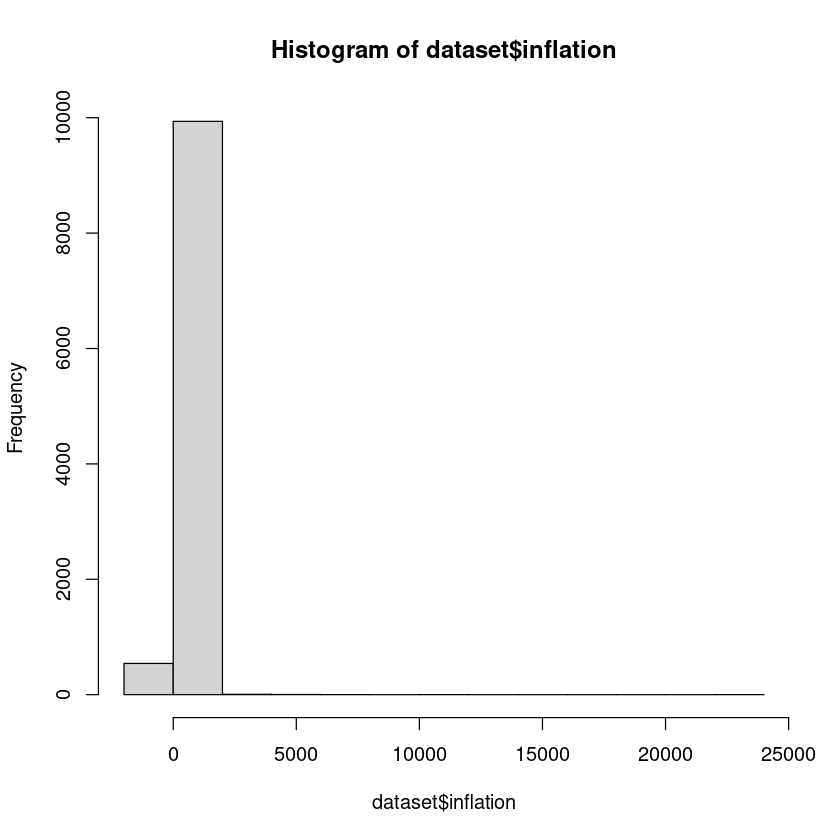

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0     0.5     3.6    13.7    19.7    91.5   14170 

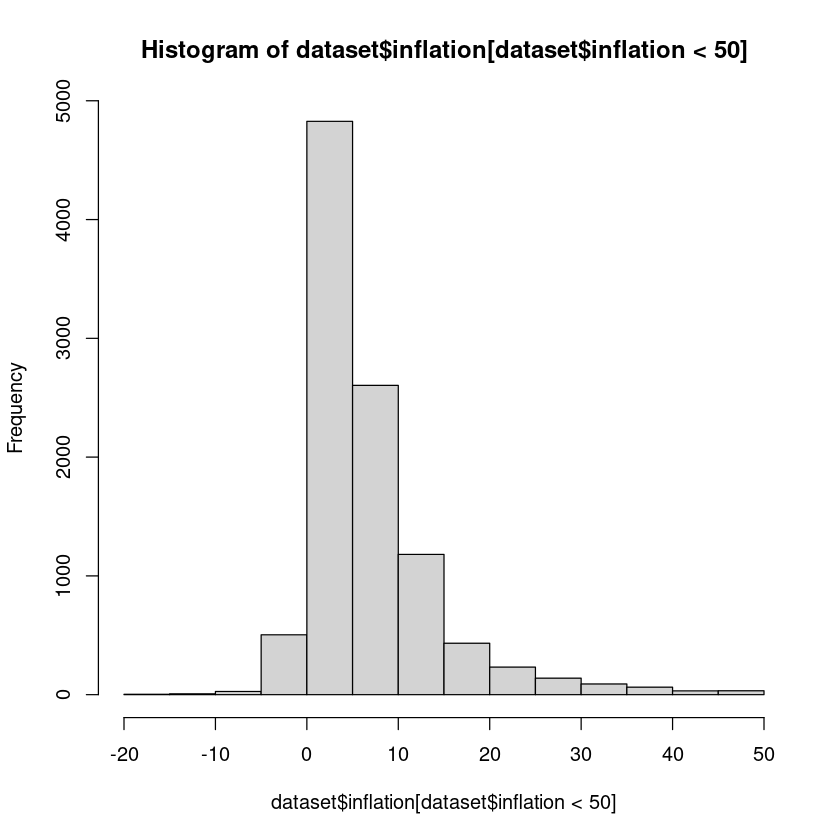

In [3]:
# We can, like last week, summarize the data and make histograms to look at its distribution
summary(dataset$gdp_per_cap_ppp)

hist(dataset$inflation)
# This one looks weird because of outliers, let's only look at cases with inflation below 50%.
hist(dataset$inflation[dataset$inflation<50])

summary(dataset$perc_below_pov_line)

Some of the data have missing values in some years. Today, we will solve this pragmatically by just using the previous years' values if an observation is missing. We have to do this _grouped by country_.


In [4]:
dataset = dataset %>% 
  group_by(iso3c) %>%
      fill(perc_below_pov_line, .direction = "down")

dataset = dataset %>% 
  group_by(iso3c) %>%
  fill(oda_per_cap, .direction = "down")

dataset = dataset %>% 
  group_by(iso3c) %>%
  fill(gdp_per_cap_ppp, .direction = "down")

We are interested in whether the effect of international aid (ODA - official development assistance) is different in countries with democracies vs. in non-democratic countries. For this we need data on demcracy. We will also get data from schooling for some later analysis. We can get this from https://ourworldindata.org/. 

We can first search for terms using the search engine in the package. Next, we can read in the data, rename it, and filter by years (and countries, if we want to).

In [5]:
owid_search("democracy")

democracy <- owid("democracy-polity",
                  rename = "democracy") %>% 
  filter(year %in% 1960:2018)


owid_search("schooling")
yos <- owid("mean-years-of-schooling-long-run",
                  rename = "years_of_schooling") %>% 
  filter(year %in% 1960:2018)


titles,chart_id
Child mortality rate vs. liberal democracy,child-mortality-vs-liberal-democracy
Age of democracy,age-of-democracy-bmr
Age of democracy,age-of-democracy-womsuffr-bmr
Age of democracy,age-of-democracy-polity
Age of electoral democracy,age-of-electoral-democracy
Age of electoral democracy,age-of-electoral-democracy-lied
Age of liberal democracy,age-of-liberal-democracy-row
Citizen satisfaction with democracy,citizen-satisfaction-with-democracy
Citizen support for democracy,citizen-support-for-democracy
Deliberative democracy,deliberative-democracy-vdem


titles,chart_id
Child mortality vs. women's average years of schooling,correlation-between-child-mortality-and-mean-years-of-schooling-for-those-aged-15-and-older
Liberal democracy today vs. past average years of schooling,liberal-democracy-today-vs-past-schooling
Average years of schooling vs. GDP per capita,average-years-of-schooling-vs-gdp-per-capita
Average years of schooling vs. expected years of schooling,average-schooling-vs-expected-schooling
Expected years of schooling vs. GDP per capita,expected-years-of-schooling-vs-gdp-per-capita
Gender ratios for average years of schooling,gender-ratios-for-mean-years-of-schooling
Fertility rate vs. average years of schooling,fertility-rate-vs-mean-years-of-schooling
Average years of schooling,mean-years-of-schooling-long-run
Average years of schooling for men,mean-years-of-schooling-male
Average years of schooling for women,mean-years-of-schooling-female


The next thing we want to do is to combine these two datasets. We can do this by a process called **merging** the data. We need to have at least one column of data that have the same identifier (for example, survey ID number, country name, year, etc.). We merge with the command `join` and we can do a `right_join` in this case because we want complete observations in the democracy data.

In [6]:
democracy$country = democracy$entity
democracy$iso3c = democracy$code 

yos$country = yos$entity
yos$iso3c = yos$code


dataset_panel <- dataset %>% 
  right_join(democracy)

dataset_panel <- dataset_panel %>% 
  left_join(yos)



dataset_panel = dataset_panel[order(dataset_panel$country, dataset_panel$year),]
head(dataset_panel)


Joining, by = c("country", "year", "iso3c")
Joining, by = c("country", "year", "iso3c", "entity", "code")


iso2c,country,year,status,lastupdated,oda_per_cap,perc_below_pov_line,gdp_per_cap_ppp,gdp_per_cap,inflation,⋯,region,capital,longitude,latitude,income,lending,entity,code,democracy,years_of_schooling
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
AF,Afghanistan,1960,,2022-09-16,1.909532,NA,NA,59.77323,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,-10,0.22
AF,Afghanistan,1961,,2022-09-16,3.781052,NA,NA,59.86090,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,-10,NA
AF,Afghanistan,1962,,2022-09-16,1.810416,NA,NA,58.45801,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,-10,NA
AF,Afghanistan,1963,,2022-09-16,3.842526,NA,NA,78.70643,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,-10,NA
AF,Afghanistan,1964,,2022-09-16,4.737925,NA,NA,82.09531,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,-7,NA
AF,Afghanistan,1965,,2022-09-16,5.416661,NA,NA,101.10833,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,-7,0.29


Next, we have to do some data cleaning and generate some additional variables. I will largely skip over this. (Note: The main problem is that we now have a _panel_ (countryXyear)( dataset, which we haven't talked about in class yet. I will convert this into a _cross-sectional_ dataset, which only has one observation (year) per unit (country) of analysis. We will talk about the exciting world of panel datasets later in class!)

In [10]:
head(dataset_panel)

# Normalize democracy scores: All will lie between 0 and 1
dataset_panel$democracy = (dataset_panel$democracy+10)/20

# Generate cross-sectional data
dataset_cs = dataset_panel %>%
  filter(year==2016)

# Make year averages

data_pov90 = dataset_panel %>%
  filter(year==1990) %>%
  group_by(iso3c) %>%
  dplyr::summarize(pov_1990 = mean(perc_below_pov_line, na.rm=TRUE))

data_aid9010 = dataset_panel %>%
  filter(year %in% 1990:2010) %>%
  group_by(iso3c) %>%
  dplyr::summarize(aid_9010 = mean(oda_per_cap, na.rm=TRUE))

# Calculate in per year amounts.
data_aid9010$aid_9010 = data_aid9010$aid_9010*20

data_dem9010 = dataset_panel %>%
  filter(year %in% 1990:2010) %>%
  group_by(iso3c) %>%
  dplyr::summarize(dem9010 = mean(democracy, na.rm=TRUE))


data_gdp1990= dataset_panel %>%
  filter(year %in% 1990) %>%
  group_by(iso3c) %>%
  dplyr::summarize(gdp1990 = mean(gdp_per_cap, na.rm=TRUE))


# Merge in year-averages
dataset_cs = dataset_cs %>% 
  left_join(data_pov90)

dataset_cs = dataset_cs %>% 
  left_join(data_aid9010)

dataset_cs = dataset_cs %>% 
  left_join(data_dem9010)

dataset_cs = dataset_cs %>% 
  left_join(data_gdp1990)


# Generate happiness variable
dataset_cs$happiness = dataset_cs$gdp_per_cap_ppp + rnorm(nrow(dataset_cs),0,1000)


head(dataset_cs)

iso2c,country,year,status,lastupdated,oda_per_cap,perc_below_pov_line,gdp_per_cap_ppp,gdp_per_cap,inflation,⋯,region,capital,longitude,latitude,income,lending,entity,code,democracy,years_of_schooling
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
AF,Afghanistan,1960,,2022-09-16,1.909532,NA,NA,59.77323,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.00,0.22
AF,Afghanistan,1961,,2022-09-16,3.781052,NA,NA,59.86090,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.00,NA
AF,Afghanistan,1962,,2022-09-16,1.810416,NA,NA,58.45801,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.00,NA
AF,Afghanistan,1963,,2022-09-16,3.842526,NA,NA,78.70643,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.00,NA
AF,Afghanistan,1964,,2022-09-16,4.737925,NA,NA,82.09531,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.15,NA
AF,Afghanistan,1965,,2022-09-16,5.416661,NA,NA,101.10833,NA,⋯,South Asia,Kabul,69.1761,34.5228,Low income,IDA,Afghanistan,AFG,0.15,0.29


Joining, by = "iso3c"
Joining, by = "iso3c"
Joining, by = "iso3c"
Joining, by = "iso3c"


iso2c,country,year,status,lastupdated,oda_per_cap,perc_below_pov_line,gdp_per_cap_ppp,gdp_per_cap,inflation,⋯,lending,entity,code,democracy,years_of_schooling,pov_1990,aid_9010,dem9010,gdp1990,happiness
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AF,Afghanistan,2016,,2022-09-16,115.00937350,NA,1981.118,512.0128,4.3838920,⋯,IDA,Afghanistan,AFG,0.5225000,3.6,NaN,262.31533,0.5134091,NaN,2024.362
NA,Africa,2016,NA,NA,NA,NA,NA,NA,NA,⋯,NA,Africa,NA,0.5312981,NA,NaN,NaN,0.5364371,NaN,NA
AL,Albania,2016,,2022-09-16,59.46939738,0.1,12078.843,4124.0554,-0.3673172,⋯,IBRD,Albania,ALB,0.5475000,10.0,NaN,1889.59518,0.5397619,617.2304,10256.608
DZ,Algeria,2016,,2022-09-16,3.56461208,0.5,11624.341,3946.4524,6.3976948,⋯,IBRD,Algeria,DZA,0.5300000,8.0,6.4,183.76602,0.5204762,2408.8230,13035.603
AO,Angola,2016,,2022-09-16,6.97824841,14.6,7103.226,1728.0238,30.6953130,⋯,IBRD,Angola,AGO,0.5200000,5.1,NaN,462.73791,0.5167857,947.7043,6265.644
AR,Argentina,2016,,2022-09-16,0.06010502,0.7,20307.870,12790.2425,NA,⋯,IBRD,Argentina,ARG,0.5475000,9.9,1.2,75.83413,0.5439286,4333.4834,19184.107


Our final datast includes the following variables of interest for our analysis:
* `gdp_per_cap_ppp`: GDP per capita in the year 2011, in PPP and real 2017 USD
* `perc_below_poverty_line`: Share of the population below the poverty line (2.15 USD per day), in 2011.
* `pov_1990`: Share of the population below the poverty line (2.15 USD per day), in 1990
* `aid_9010`: Total development aid received (in USD), per capita, over the years 1990-2010
* `dem_9010`: Average democracy level between 1990 and 2010 (between 0 and 1)
* `happiness`: A fictional happiness score, in 2011

Our hypothesis is that development aid has an effect on the welfare of a country, measured by GDP per capita and the poverty rate. Maybe aid takes many years to have an effect, so we take the sum over 1990 to 2010 and see how this affected our outcomes in 2011. We are also wondering whether democracy was related to welfare, and so we also average the democracy score between 1990 and 2010 to keep everything comparable.


## Analysis: Analyzing interaction terms
Last week, I gave a hint that we will talk about interaction terms. Interaction terms can help us to understand questions such as:
* Does having a child have a **different effect** on wages for men and women?
* Do children from different socio-economic backgrounds **respond differently** to free school meals?
* Does development aid **work better** in democratic as opposed to non-democratic countries?

We quickly analyze the math of this model on the blackboard.

Let's run the regression!

In [11]:
nointeraction_pov <- lm(perc_below_pov_line ~ pov_1990 +  aid_9010 + dem9010 , data=dataset_cs)

interaction_pov <- lm(perc_below_pov_line ~  pov_1990 +  aid_9010 + dem9010 + I(aid_9010*dem9010), data=dataset_cs)

nointeraction_gdp <- lm(gdp_per_cap_ppp ~ pov_1990 +  aid_9010 + dem9010 , data=dataset_cs)

interaction_gdp <- lm(gdp_per_cap_ppp ~  pov_1990 +  aid_9010 + dem9010 + I(aid_9010*dem9010), data=dataset_cs)


export_summs(nointeraction_pov, interaction_pov, nointeraction_gdp, interaction_gdp)


,names,Model 1,Model 2,Model 3,Model 4
,<chr>,<chr>,<chr>,<chr>,<chr>
,,Model 1,Model 2,Model 3,Model 4
1,(Intercept),-61.2374795071691,-128.785951684016,-100473.050623957,743.840399071715
2,,(131.151998543101),(184.46296744571),(50308.6071500479),(65918.4780877931)
3,pov_1990,0.465746047021812 ***,0.478817136761546 ***,-170.119670411957 **,-189.705828663991 ***
4,,(0.125929692234316),(0.129811946126957),(48.3053821940856),(46.388746992385)
5,aid_9010,0.00143573381067744,0.0889241284377262,1.78207531734834,-129.313462736596 *
6,,(0.00237476791877688),(0.165961798407396),(0.910937443770791),(59.3070214754539)
7,dem9010,111.590525363933,236.236210579241,217161.635844753 *,30388.3702126576
8,,(243.232174121096),(341.274800056792),(93301.451979696),(121955.727704969)


## Bad controls
When we talked about omitted variables, we always talked about how forgetting an important variable can have bad consequences for your analysis. But there is also the opposite problem: Bad controls!
The bad controls problem arises when we control for a variable in a regression that is actually an outcome (a variable on the left-hand side). 

For example:
* A treatment gives people money at time t, and we want to study how it changes their consumption at time t+1. We control for their wage at time t+1.
* We want to study whether winning the lottery at time t makes you happier at time t+1. We control for whether you bought a Ferrari at time t+1.

Let's make an example. We know that happiness is strongly related to income (at least, to some extent: https://ourworldindata.org/happiness-and-life-satisfaction ). Aid in the past will affect income today and happiness today. Therefore, controlling for happiness today introduces a bad control problem!

In [14]:
basic_regression <- lm( gdp_per_cap_ppp ~  gdp1990 , data=dataset_cs)

bad_controls <- lm( gdp_per_cap_ppp ~  gdp1990  + happiness, data=dataset_cs)

export_summs(basic_regression, bad_controls)


,names,Model 1,Model 2
,<chr>,<chr>,<chr>
,,Model 1,Model 2
1,(Intercept),7978.42432394203 ***,-47.7777015498555
2,,(1239.0877614923),(138.307999063505)
3,gdp1990,2.04469323680988 ***,0.00333770097061518
4,,(0.11501970977029),(0.021294596424702)
5,happiness,,0.999164381516758 ***
6,,,(0.00893164138740528)
1.1,N,117,117
2.1,R2,0.733189781839178,0.997591438771217


We can interpret bad controls through the OVB formula we learnt last time:

$$ \rho_s = \rho + \gamma \cdot \delta $$

where $\rho$ is the "long" coefficient, $\gamma$ is the coefficient of the omitted variable in the long regression, $\delta$ is the coefficient in the auxiliary regression (regress omitted variable on included variable), and $\rho_s$ is the "short" regression coefficient.

Remember? It told you that this formula **ALWAYS** holds - no matter what variable I include. 

Extreme case: Include GDP$\times$10 on the RHS - what will happen?

## Do you need an OVB revision?

In [15]:
# Revise OVB
a = lm(log(gdp_per_cap_ppp) ~  democracy  , data=dataset_cs)
b = lm(log(gdp_per_cap_ppp) ~ years_of_schooling +  democracy  , data=dataset_cs)
c = lm(years_of_schooling  ~ democracy  , data=dataset_cs)
export_summs(a,b,c)

,names,Model 1,Model 2,Model 3
,<chr>,<chr>,<chr>,<chr>
,,Model 1,Model 2,Model 3
1,(Intercept),1.09009171786149,8.96440800542877 ***,-25.4438428120717 **
2,,(3.5845626524535),(1.94872769203634),(8.62215636672121)
3,democracy,15.2527368966298 *,-4.28199504589645,63.1104742397465 ***
4,,(6.67806650043998),(3.69542563257363),(16.0966995706918)
5,years_of_schooling,,0.313394531780118 ***,
6,,,(0.0166755807608285),
1.1,N,145,144,162
2.1,R2,0.035196299293719,0.725080867999958,0.0876534587488713


## Data visualizations
An important skill - this is just a quick example and we'll do more in the next weeks!

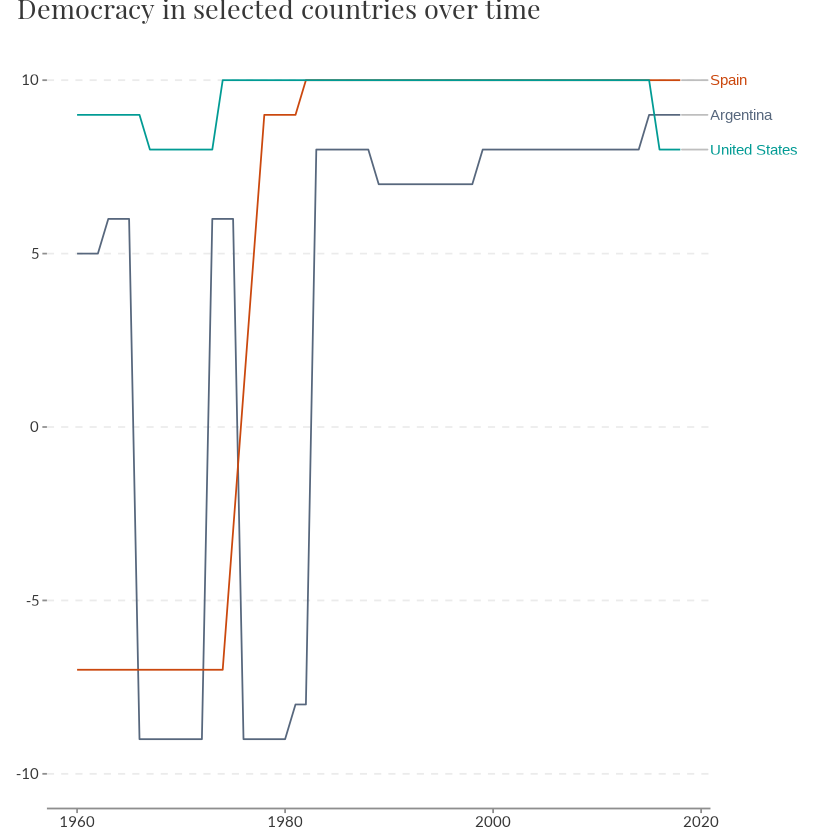

In [16]:
a = c("Argentina","Spain", "United States")
owid_plot(democracy, filter = a, summarise=FALSE) +
  labs(title = paste0("Democracy in selected countries over time")) +
  scale_y_continuous(limits = c(-10, 10))


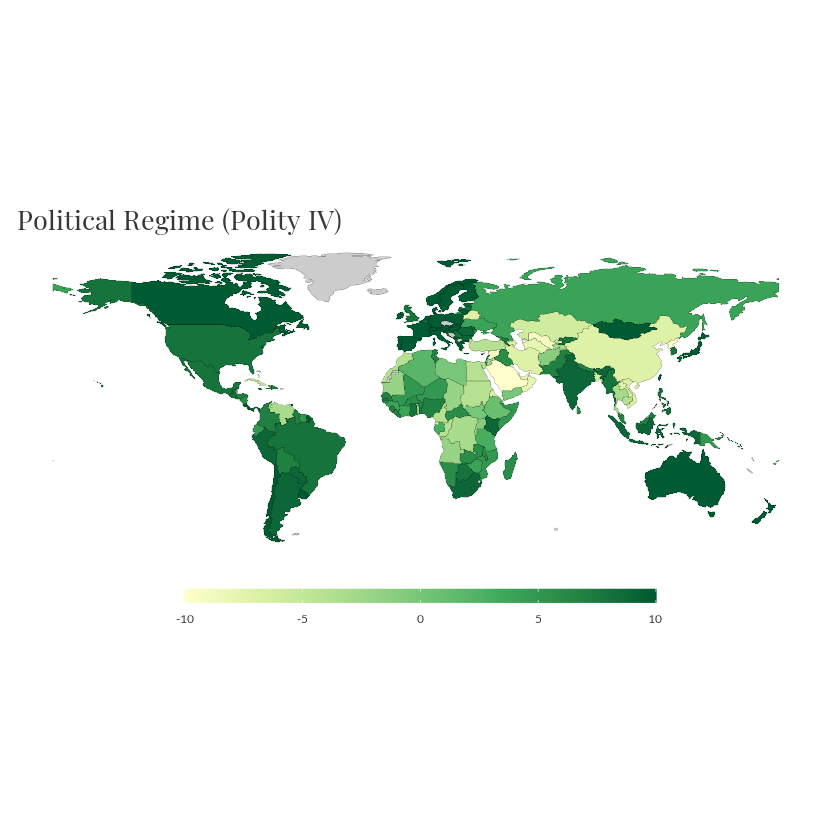

In [17]:
# Make a map

democracy2 <- owid("democracy-polity",
                   rename = "democracy") %>% 
  filter(year==2018)

owid_map(democracy2, palette = "YlGn") +
  labs(title = "Political Regime (Polity IV)")